# 1. Lets use YAHOO FINANCE API for data gathering

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf  # Yahoo Finance API
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

In [23]:
# Set the ticker symbol, start date, and end date
ticker = "AAPL"  # Apple Inc.
start_date = "2018-01-01"
end_date = "2022-12-31"

# Download the stock data
data = yf.download(ticker, start=start_date, end=end_date)

# Display information about the data
print("Data shape:", data.shape)
print("\nDate range:")
print(f"Start: {data.index.min()}")
print(f"End: {data.index.max()}")
print("\nFirst few rows:")
print(data.head())

[*********************100%***********************]  1 of 1 completed

Data shape: (1259, 5)

Date range:
Start: 2018-01-02 00:00:00
End: 2022-12-30 00:00:00

First few rows:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.479839  40.489241  39.774861  39.986357  102223600
2018-01-03  40.472778  41.017963  40.409333  40.543277  118071600
2018-01-04  40.660778  40.764175  40.437536  40.545630   89738400
2018-01-05  41.123718  41.210664  40.665483  40.757130   94640000
2018-01-08  40.970974  41.267063  40.872274  40.970974   82271200


In [24]:
# Check for any missing values
print("\nMissing values in each columns:")
print(data.isnull().sum())
#Basic Stats
print("\Basic Statistics:")
print(data.describe())


Missing values in each columns:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64
\Basic Statistics:
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03
mean      95.702890    96.801484    94.519861    95.640169  1.168806e+08
std       46.139145    46.720911    45.520935    46.131170  5.504461e+07
min       33.915260    34.757238    33.869941    34.342211  3.519590e+07
25%       48.939255    49.328000    48.508396    48.946823  8.014245e+07
50%       89.189919    90.491765    88.486683    88.846815  1.023002e+08
75%      140.533104   141.942093   138.793239   140.569237  1.372052e+08
max      178.879913   179.793936   176.039622   179.489269  4.265100e+08


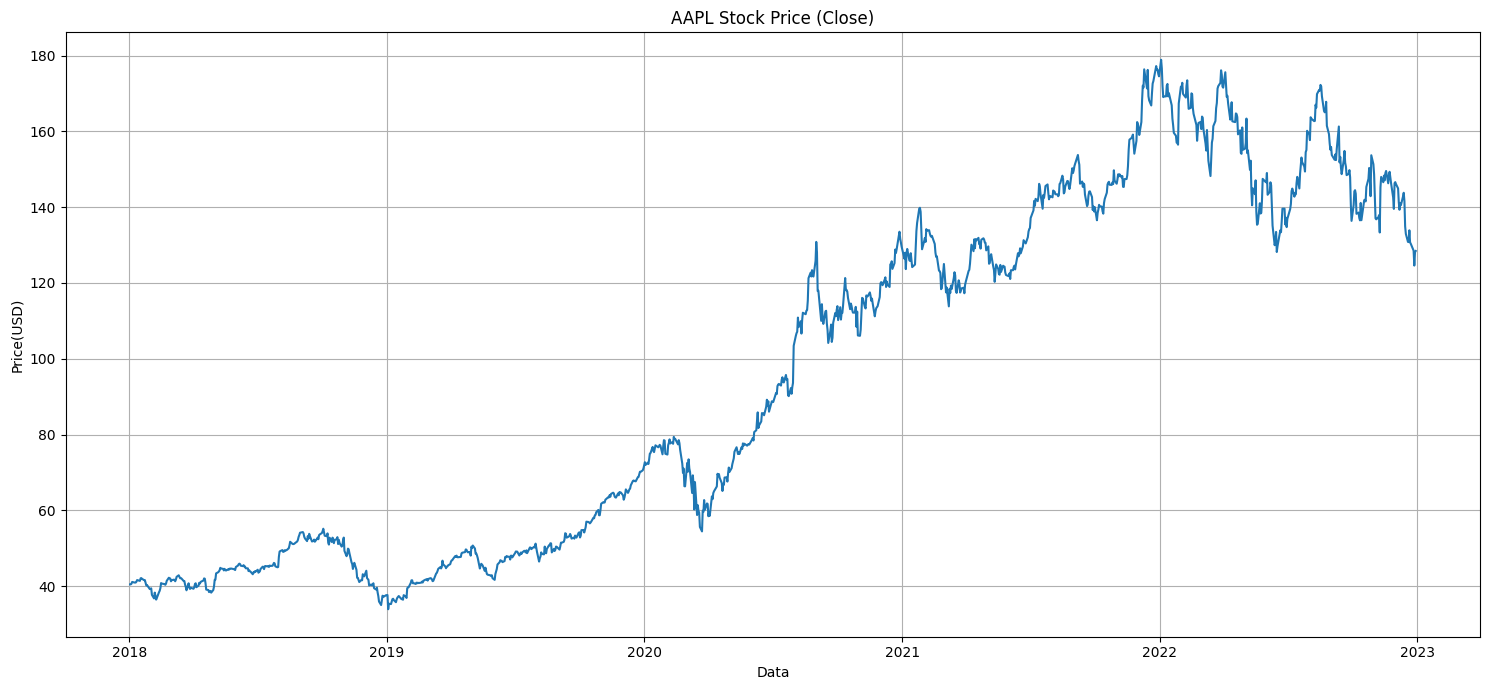

In [25]:
#Plor the closing price over time
plt.figure(figsize=(15,7))
plt.plot(data.index, data['Close'])
plt.title(f'{ticker} Stock Price (Close)')
plt.xlabel('Data')
plt.ylabel('Price(USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Feature Engineering for Time-Series

In [26]:
# Create a copy of the original data
stock_data = data.copy()

#Extract Date features
stock_data['Year'] = stock_data.index.year
stock_data['Month'] = stock_data.index.month
stock_data['Day'] = stock_data.index.day
stock_data['DayOfWeek'] = stock_data.index.dayofweek

#Calculate price-based features
stock_data['PriceRange'] = stock_data['High']-stock_data['Low']
stock_data['DailyReturn'] = stock_data['Close'].pct_change()

# Create Lagged features (previous days' prices)
for lag in range(1, 6):
    stock_data[f'Close_Lag_{lag}'] = stock_data['Close'].shift(lag)
    stock_data[f'Volume_Lag_{lag}'] = stock_data['Volume'].shift(lag)

# Calculate moving average
for window in [5, 10, 20, 50]: #common moving average windows
    stock_data[f'MA_{window}'] = stock_data['Close'].rolling(window=window).mean()

# Calculate technical indicators
# Relative Strength Indec (RSI) -  simplfied version
delta = stock_data['Close'].diff()
gain = delta.where(delta>0,0)
loss = -delta.where(delta<0,0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain/avg_loss
stock_data['RSI'] = 100-(100/(1+rs))

# Moving Average Convergence Divergence (MACD)
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26).mean()
stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']
stock_data['MACD_Signal'] = stock_data['MACD'].ewm(span=9).mean()

# DROP rows with NAN values
stock_data = stock_data.dropna()

print("Features create. New Shape:", stock_data.shape)
print("\nColumns:", stock_data.columns.tolist())

Features create. New Shape: (1210, 30)

Columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL'), ('Year', ''), ('Month', ''), ('Day', ''), ('DayOfWeek', ''), ('PriceRange', ''), ('DailyReturn', ''), ('Close_Lag_1', ''), ('Volume_Lag_1', ''), ('Close_Lag_2', ''), ('Volume_Lag_2', ''), ('Close_Lag_3', ''), ('Volume_Lag_3', ''), ('Close_Lag_4', ''), ('Volume_Lag_4', ''), ('Close_Lag_5', ''), ('Volume_Lag_5', ''), ('MA_5', ''), ('MA_10', ''), ('MA_20', ''), ('MA_50', ''), ('RSI', ''), ('EMA_12', ''), ('EMA_26', ''), ('MACD', ''), ('MACD_Signal', '')]


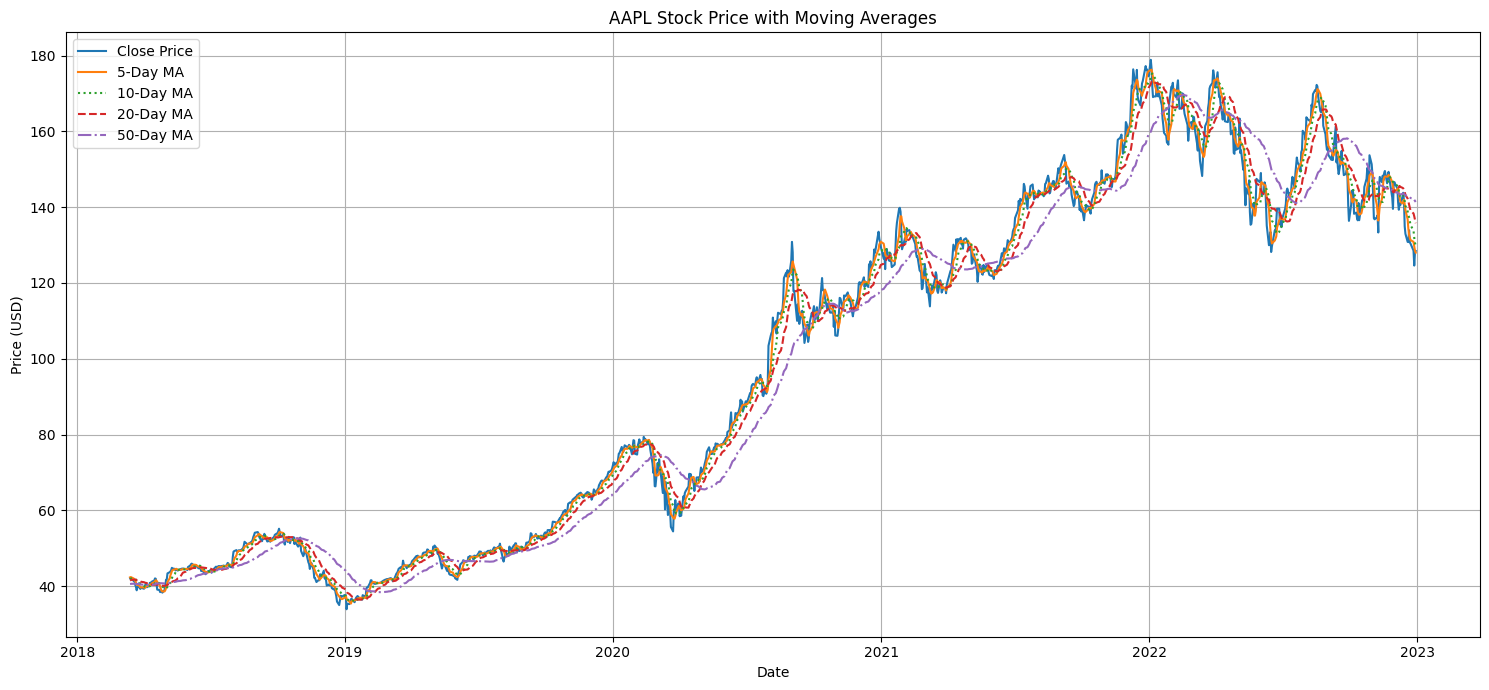

In [27]:
# Visualize Key Features
# Plot closing price with moving averages
plt.figure(figsize=(15, 7))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price')
plt.plot(stock_data.index, stock_data['MA_5'], label='5-Day MA', linestyle='-')
plt.plot(stock_data.index, stock_data['MA_10'], label='10-Day MA', linestyle=':')
plt.plot(stock_data.index, stock_data['MA_20'], label='20-Day MA', linestyle='--')
plt.plot(stock_data.index, stock_data['MA_50'], label='50-Day MA', linestyle='-.')
plt.title(f'{ticker} Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

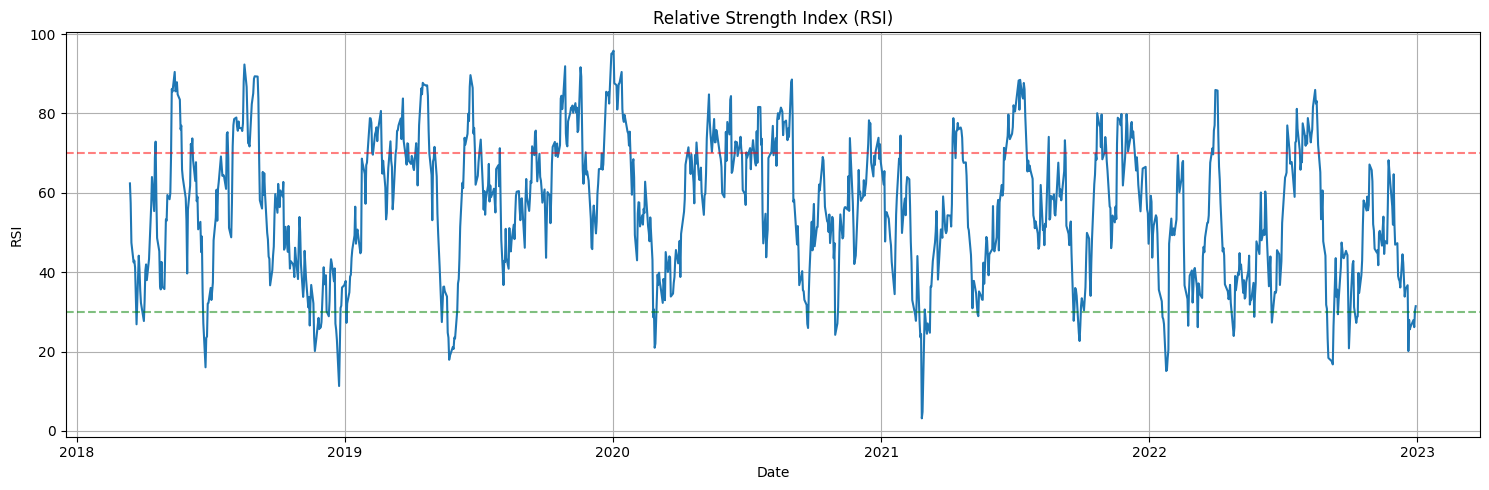

In [28]:
# Plot RSI
plt.figure(figsize=(15, 5))
plt.plot(stock_data.index, stock_data['RSI'])
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)  # Overbought line
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)  # Oversold line
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid(True)
plt.tight_layout()
plt.show()

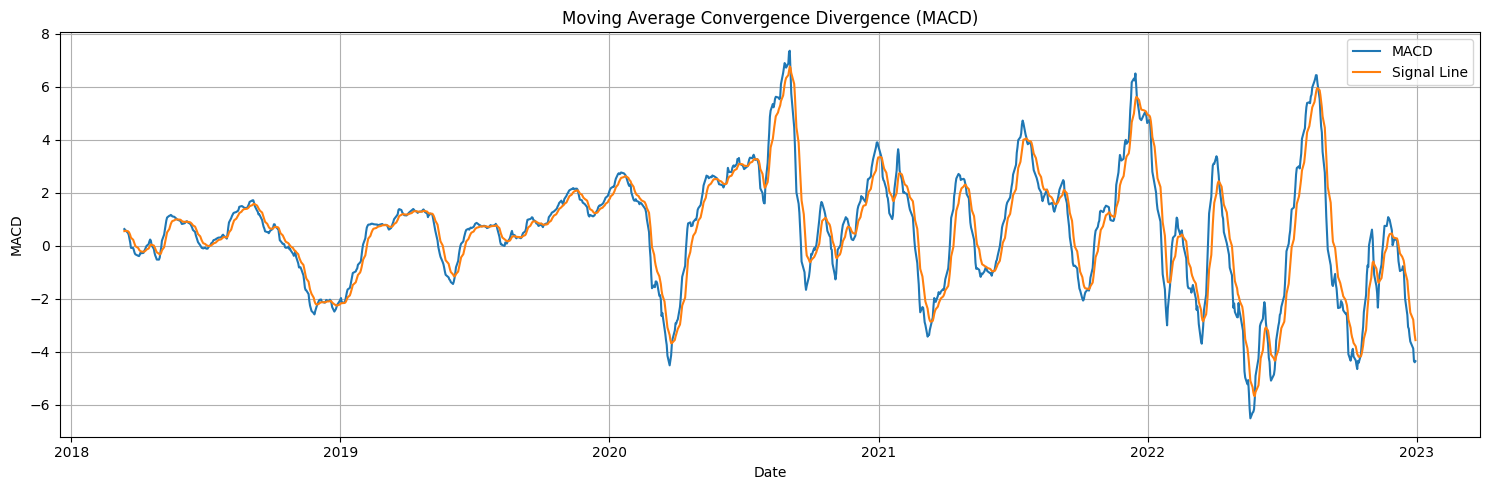

In [29]:
# Plot MACD
plt.figure(figsize=(15, 5))
plt.plot(stock_data.index, stock_data['MACD'], label='MACD')
plt.plot(stock_data.index, stock_data['MACD_Signal'], label='Signal Line')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# Define prediction target: next day's closing price
stock_data['Target'] = stock_data['Close'].shift(-1) # tomorrow's closing price
# Drop specifically the last row which has no target
stock_data = stock_data.iloc[:-1]
# Then drop any remaining rows with NaN values from our feature engineering
stock_data = stock_data.dropna()
display(stock_data)
# Define features and target


Price,Close,High,Low,Open,Volume,Year,Month,Day,DayOfWeek,PriceRange,...,MA_5,MA_10,MA_20,MA_50,RSI,EMA_12,EMA_26,MACD,MACD_Signal,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
